In [2]:
import xarray as xr
import numpy as np
import os
import optuna
from glob import glob
import tqdm


import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.lines import Line2D
import seaborn as sb
from cycler import cycler

In [28]:
colors = {
    0.5: 'tab:blue',
    1.5: 'tab:red',
    2.5: 'tab:purple'
}

In [63]:
rerun = False

if not rerun:
    raise ValueError(
        '`rerun=False`. set `True` if you want to rerun (~12 min).'
    )

raise KeyboardInterrupt # do only call once to aggregate logs from files. Uncomment to run cell.

paths = glob(f'../logs/experiment_02/lightning_logs/version_*/predictions.nc')
ds_all = xr.open_dataset(paths[0]).q10
ds_all.values[:] = np.nan
ds_all = ds_all.expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4], 'weight_decay': [0.0, 0.01, 0.1], 'rep': np.arange(10), 'use_ta': [0, 1]}).copy()

ds_counter = xr.open_dataset(paths[0]).q10.isel(iter=0).drop('iter').expand_dims(
    {'q10_init': [0.5, 1.5, 2.5], 'dropout': [0.0, 0.2, 0.4], 'weight_decay': [0.0, 0.01, 0.1], 'use_ta': [0, 1]}).astype('int').copy()
ds_counter.values[:] = 0

error_count = 0
for i, p in enumerate(tqdm.tqdm(paths)):

    try:
        ds = xr.open_dataset(p)
    except:
        error_count += 1
        continue

    weight_decay = ds.attrs['weight_decay']
    q10_init = ds.attrs['q10_init']
    dropout = ds.attrs['dropout']
    use_ta = bool(ds.attrs['use_ta'])
    use_scheduler = bool(ds.attrs['use_scheduler'])

    if use_scheduler:
        continue

    rep = ds_counter.sel(q10_init=q10_init, dropout=dropout, weight_decay=weight_decay, use_ta=int(use_ta))

    if rep == 10:
        continue

    ds_all.loc[
        dict(
            q10_init=q10_init,
            dropout=dropout,
            weight_decay=weight_decay,
            use_ta=int(use_ta),
            rep=rep)
    ] = ds.q10.values

    ds_counter.loc[dict(q10_init=q10_init, dropout=dropout, weight_decay=weight_decay, use_ta=int(use_ta))] += 1

    if (ds_counter == 1).all().item():
        break

ds_all.to_netcdf('../logs/experiment_02/lightning_logs/predictions_grid.nc')

100%|██████████| 6972/6972 [10:46<00:00, 10.78it/s]


In [4]:
ds_all = xr.open_dataset('../logs/experiment_02/lightning_logs/predictions_grid.nc').load()

In [32]:
def plot_grid(with_temp):
    fig, axes = plt.subplots(3, 3, figsize=(6, 5), sharey=True, sharex=True, gridspec_kw={'hspace': 0, 'wspace': 0})

    for i, dropout in enumerate(tqdm.tqdm(ds_all['dropout'].values)):
        for j, weight_decay in enumerate(ds_all['weight_decay'].values):
            ds = ds_all.sel(dropout=dropout, weight_decay=weight_decay, use_ta=int(with_temp))
            ax = axes[i, j]

            for q10_init in ds_all['q10_init'].values:
                color = colors[q10_init]
                for r in range(10):
                    ds.q10.sel(q10_init=q10_init, rep=r).plot(color=color, ax=ax, lw=0.8)

            ax.axhline(1.5, ls='--', color='k', lw=0.8)
            ax.set_xticks([0, 1000, 2000])
            ax.text(0.5, 0.95, f'weight decay: {weight_decay}\ndropout: {dropout}',
                horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
            ax.set_title('')

            if (i == 1) and (j == 0):
                ax.set_ylabel(r'$Q_{10}$')
            else:
                ax.set_ylabel('')

            if (i == 2) and (j == 1):
                ax.set_xlabel('Training iteration')
            else:
                ax.set_xlabel('')

    custom_lines = [Line2D([0], [0], color=colors[0.5], lw=4),
                    Line2D([0], [0], color=colors[1.5], lw=4),
                    Line2D([0], [0], color=colors[2.5], lw=4),
                    Line2D([0], [0], color='k', ls='--', lw=4)]

    axes[0, 1].legend(
        custom_lines, ['0.5', '1.5', '2.5', r'groundtruth'],
        title=r'Initial $Q_{10}$', ncol=4,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.05),
        frameon=False
        )

    fig.tight_layout()
    fig.savefig(f'./plots/q10_{"wi" if with_temp else "wo"}_ta.png', dpi=300, transparent=False, facecolor='w')

100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


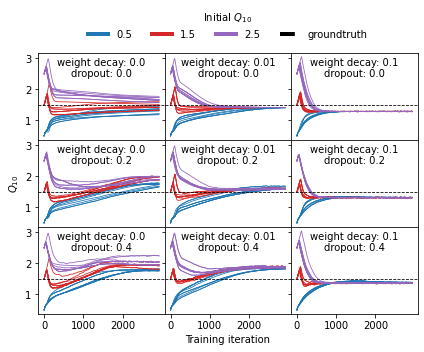

In [34]:
plot_grid(True)

In [127]:
df_all = ds_all.to_dataframe().reset_index()

In [193]:
def plot_grid(df, with_temp):
    df = df[df['use_ta']==int(with_temp)]#.iloc[:100, :]
    g = sb.relplot(
        x='iter', y='q10', col='dropout', row='weight_decay', hue='q10_init', style='rep',
        data=df, kind='line', dashes=False, height=2, aspect=1.5, palette='colorblind', alpha=0.5)

    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i, j]
            ax.axhline(1.5, ls=':', color='k', lw=1.4)

            if (i == 1) and (j == 0):
                ax.set_ylabel(r'$Q_{10}$')
            else:
                ax.set_ylabel('')

            if (i == 2) and (j == 1):
                ax.set_xlabel('Training iteration')
            else:
                ax.set_xlabel('')

    g.legend.remove()

    h, l = g.axes[0, 0].get_legend_handles_labels()

    g.axes[0, 1].legend(
        [Line2D([0], [0], color='k', ls=':', lw=1)] + h[1:4],
        [r'$Q_{10}$ true'] + l[1:4],
        frameon=False,
        ncol=4,
        title=r'$Q_{10}$ init',
        loc='lower center',
        bbox_to_anchor=(0.5, 1.1))

    #plt.savefig(f'./plots/q10_{"wi" if with_temp else "wo"}_ta.png', dpi=300, transparent=False, facecolor='w')
    g.savefig(f'./plots/q10_{"wi" if with_temp else "wo"}_ta.png', dpi=300, transparent=False, facecolor='w')

    return g

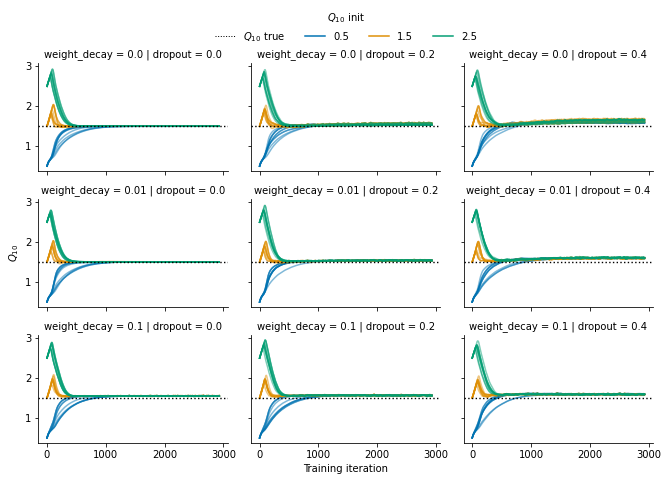

In [195]:
g = plot_grid(df_all, False)

In [201]:
study = optuna.study.load_study(study_name='q10hybrid', storage='sqlite:////Net/Groups/BGI/people/bkraft/git/q10hybrid/logs/experiment_02/optuna.db')
df = study.trials_dataframe()[[
    'value',
    'params_weight_decay',
    'params_q10_init',
    'params_dropout',
    'params_use_ta',
    'params_use_scheduler',
    'user_attrs_q10']]
df = df[df['params_use_scheduler'] == True]

In [202]:
df = df.rename(columns={
    'value': 'loss',
    'params_weight_decay': 'weight decay',
    'params_q10_init': 'Q10 init',
    'params_dropout': 'dropout',
    'user_attrs_q10': 'Q10',
    'params_use_ta': 'With temperature'
})
df

loss  weight decay  Q10 init  dropout  With temperature  \
1     0.040222          0.10       0.5      0.2              True   
2     0.000054          0.00       2.5      0.0              True   
3     0.003890          0.01       0.5      0.0              True   
4     0.000140          0.00       1.5      0.0              True   
5     0.000140          0.00       1.5      0.0              True   
...        ...           ...       ...      ...               ...   
7051  0.055213          0.10       0.5      0.4             False   
7052  0.055213          0.10       0.5      0.4             False   
7053  0.055213          0.10       0.5      0.4             False   
7054  0.055213          0.10       0.5      0.4             False   
7055  0.055213          0.10       0.5      0.4             False   

      params_use_scheduler       Q10  
1                     True  1.313839  
2                     True  1.525596  
3                     True  1.411915  
4                     True  1.500347  
5                     True  1.500347  
...                    ...       ...  
7051                  True  1.591898  
7052                  True  1.591898  
7053                  True  1.591898  
7054                  True  1.591898  
7055                  True  1.591898  

[3600 rows x 7 columns]

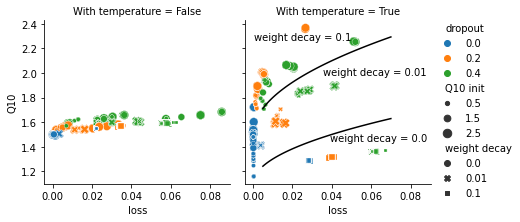

In [274]:
g = sb.relplot(x='loss', y='Q10', hue='dropout', size='Q10 init', col='With temperature', style='weight decay', data=df, palette='colorblind', height=3, aspect=1)

x = np.linspace(0.005, 0.07, 100)

#g.axes[0, 1].plot(x, np.sqrt(x)*10.1)
#g.axes[0, 1].plot(x, np.sqrt(x)*1.6)

ax = g.axes[0, 1]
ax.plot(x, np.sqrt(x) * 2 + 1.1, color='k')
ax.plot(x, np.sqrt(x) * 3 + 1.5, color='k')

ax.text(0.98, 0.28, f'weight decay = 0.0',
    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
ax.text(0.98, 0.68, f'weight decay = 0.01',
    horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
ax.text(0.05, 0.9, f'weight decay = 0.1',
    horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

g.savefig(f'./plots/q10_interctions.png', dpi=300, transparent=False, facecolor='w')

<AxesSubplot:title={'center':'With temperature = True'}, xlabel='loss'>

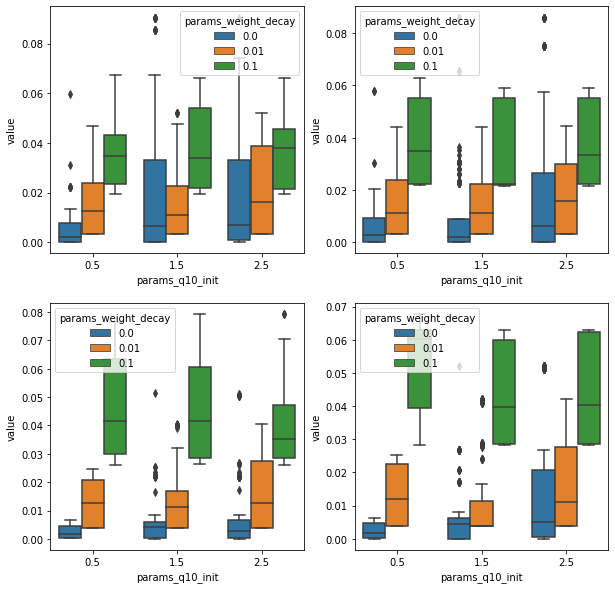

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        df_ = df[(df['params_use_ta'] == bool(i)) & (df['params_use_scheduler'] == bool(j))]
        sb.boxplot(x='params_q10_init', y='value', hue='params_weight_decay', data=df_, ax=ax)

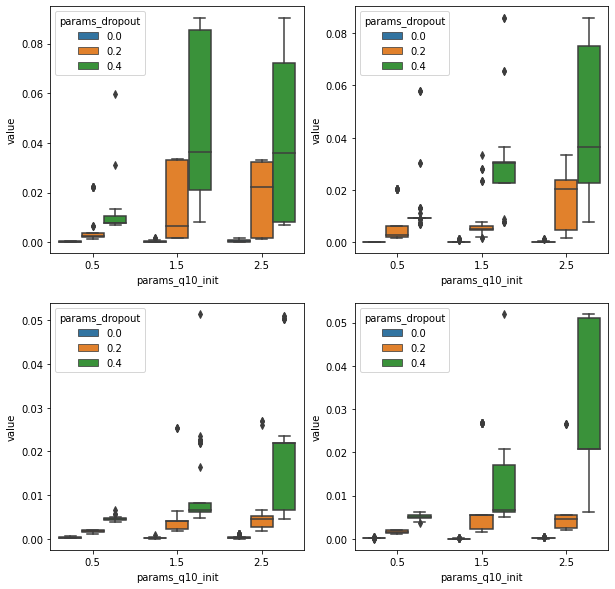

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        df_ = df[(df['params_use_ta'] == bool(i)) & (df['params_use_scheduler'] == bool(j)) & (df['params_weight_decay'] == 0.0)]
        sb.boxplot(x='params_q10_init', y='value', hue='params_dropout', data=df_, ax=ax)

In [25]:
ds = xr.open_dataset('../logs/experiment_01/n_ta/lightning_logs/version_0/predictions.nc')

In [26]:
epoch = 0

In [27]:
ds.isel(epoch=slice(0, epoch + 1))

<xarray.Dataset>
Dimensions:    (epoch: 1, iter: 1015, time: 17520)
Coordinates:
  * time       (time) datetime64[ns] 2007-01-01T00:15:00 ... 2007-12-31T23:45:00
  * epoch      (epoch) int64 0
  * iter       (iter) int64 0 1 2 3 4 5 6 ... 1008 1009 1010 1011 1012 1013 1014
Data variables:
    reco       (time) float64 ...
    rb         (time) float64 ...
    reco_pred  (epoch, time) float64 ...
    rb_pred    (epoch, time) float64 ...
    q10        (iter) float32 ...
Attributes:
    created:  2021-04-26 13:52:05
    author:   bkraft@bgc-jena.mpg.de

In [9]:
ds.q10[-1].item()

0.8793606758117676

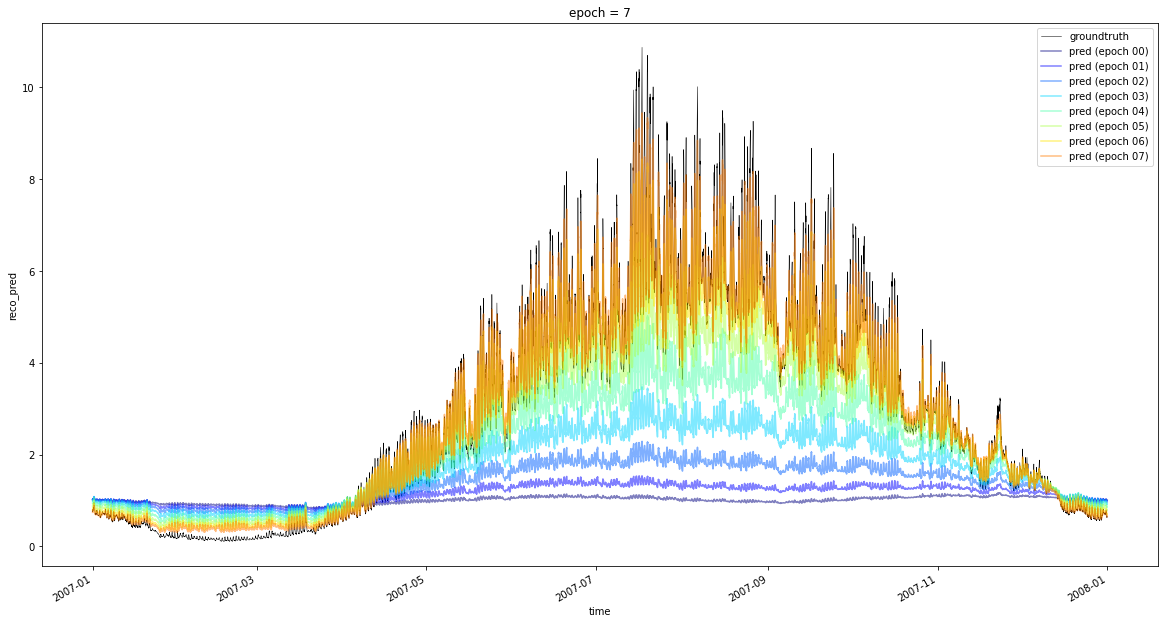

In [28]:
fig = plt.figure(figsize=(20, 10))
ax = plt.gca()

ax.set_prop_cycle(cycler(color=cmap.jet(np.linspace(0, 1, 10))))


ds['reco'].plot(color='k', lw=0.5, label='groundtruth')
for i in range(8):
    ds['reco_pred'].isel(epoch=i).plot(alpha=0.5, ax=ax, label=f'pred (epoch {i:02d})')

plt.legend()

In [46]:
import torch

In [50]:
optimizer = torch.optim.AdamW(
        [
            {
                'params': [torch.nn.Parameter(torch.ones(1) * 1)],
                'lr': 0.1,
                'weight_decay': 0.1
            },
            {
                'params': [torch.nn.Parameter(torch.ones(1) * 2)],
                'lr': 0.1,
                'weight_decay': 0.0
            }]
    )

In [54]:
1.4 // 2

0.0

In [52]:
import optuna